# 一次元タスクでのRuLSIFとMCEWの比較

## 元データ生成
No Bias Left Behind: Covariate Shift Adaptation for Discriminative 3D Pose Estimationでのtoy practiceでの設定

In [4]:
import autopep8
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools as it
%matplotlib inline

In [21]:
def gen_x(y):
    return y + 0.3 * np.sin(2*np.pi*y) + np.random.normal(loc=0.0, scale=0.05, size=len(y))

In [54]:
np.random.seed(123)
# data size setting
data_size_train = 200
data_size_test = 400

# generate train /test data
test_y = np.concatenate((np.random.normal(0.9, scale=0.03, size=int(data_size_test/2)),
                         np.random.normal(0.1, scale=0.03, size=int(data_size_test/2))))
test_x = gen_x(test_y)

train_y = np.random.uniform(size=data_size_train)
train_x = gen_x(train_y)

Text(0,0.5,'y')

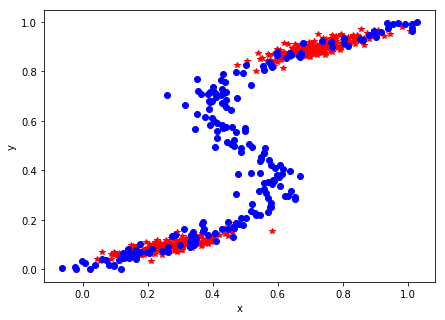

In [55]:
plt.figure(figsize=(7, 5))
plt.plot(test_x, test_y, 'r*', label='test')
plt.plot(train_x, train_y, 'bo', label='train')
plt.xlabel('x')
plt.ylabel('y')

(array([19., 58., 79., 35., 10., 25., 59., 79., 31.,  5.]),
 array([0.04454024, 0.14061836, 0.23669649, 0.33277461, 0.42885273,
        0.52493085, 0.62100897, 0.71708709, 0.81316522, 0.90924334,
        1.00532146]),
 <a list of 10 Patch objects>)

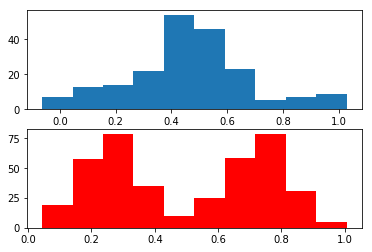

In [66]:
plt.subplot(2,1,1)
plt.hist(train_x)
plt.subplot(2,1,2)
plt.hist(test_x, color = 'r')

## RuLSIFでの重み付け
*Relative unconstrained least-squares importance fitting*の略。重みをカーネル関数の足し合わせ(係数未知)として、この係数を真の相対重要度（密度比）との２乗誤差を最小化するという学習基準に基づいて学習する。二乗誤差を学習基準にすることで、ロバストな重み付が学習できるそう(杉山先生の資料(2013)より)

実装は[こちら](http://allmodelsarewrong.org/RuLSIF.html)を拝借している

密度比推定の論文は、求めているものは密度比$\frac{p_{test}(x)}{p_{train}(x)}$になるので, entropy estimatorでの重みの総和1制約のようなものは存在しない

In [99]:
from pyRULSIF import *
from pylab import *

In [123]:
# x_nu: samples from numerator(test data)
# x_de: samples from denominator(train data)
# x_re: reference sample
# alpha: alpha defined in relative density ratio
# sigma_list, lambda_list: parameters for model selection
# b: number of kernel basis
# fold: number of fold for cross validation

In [84]:
np.random.seed(1)
# generate data.
x_nu = randn(1, 50)*.25 - 1
x_de = randn(1, 100)*.5
x_re = array([arange(-1.5, 1.5, .05)])

In [100]:
# using normal ULSIF, which is RULSIF with alpha = 0.
alpha = 0
PE, w, s = R_ULSIF(x_nu, x_de, c_[x_re, x_nu, x_de], alpha,
                   sigma_list(x_nu, x_de), lambda_list(), x_nu.shape[1], 5)

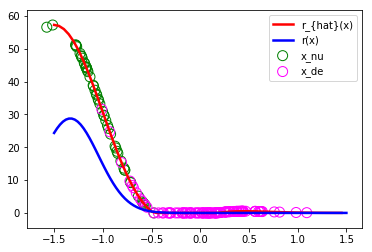

alpha =  0
divergence =  19.84959541447472


In [112]:
# plotting with true density ratio
w_re = w[0:x_re.shape[1]]
plot(x_re.T, w_re, label='r_{hat}(x)', linewidth=2.5, color='red')
w_nu = w[x_re.shape[1]:x_re.shape[1]+x_nu.shape[1]]
scatter(x_nu, w_nu, label='x_nu', color='green', facecolors='none', s=100)
w_de = w[x_re.shape[1]+x_nu.shape[1]:]
scatter(x_de, w_de, label='x_de', color='magenta', facecolors='none', s=100)

x_disp = linspace(-1.5, 1.5, 100)
plot(x_disp, norm_pdf(x_disp, -1, .25)/norm_pdf(x_disp, 0, .5),
     linewidth=2.5, label='r(x)', color='blue')
legend()
show()

print('alpha = ', alpha)
print('divergence = ', PE)